- LSTM forecast pipeline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


C:\Users\rafae\AppData\Local\Temp\ipykernel_22212\1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


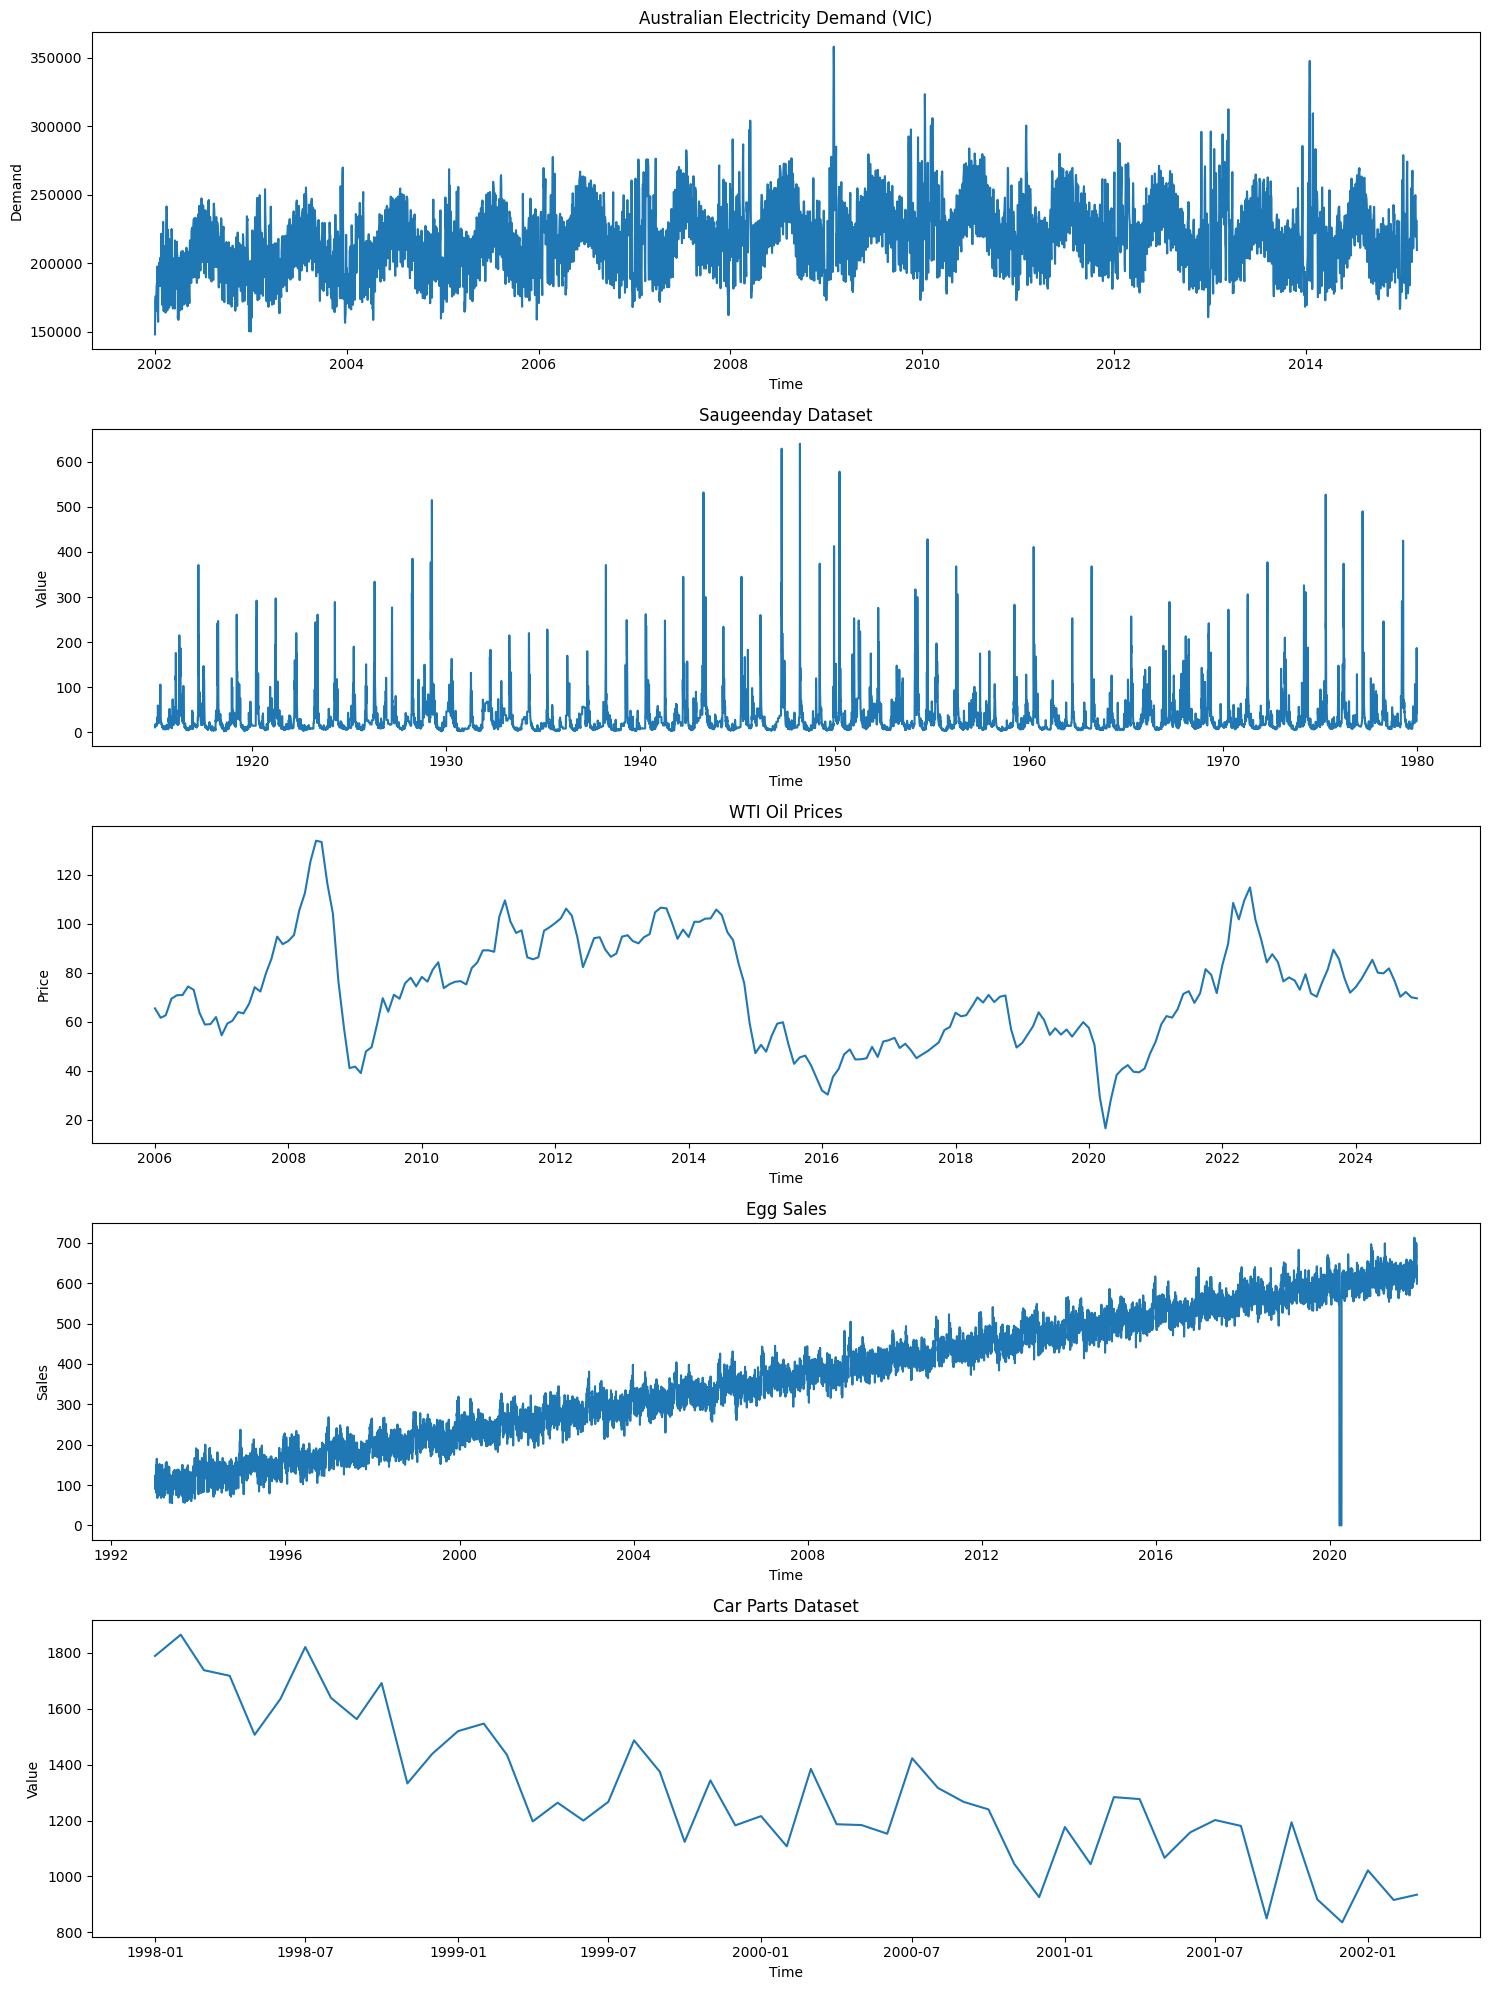

In [50]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def lstm_forecast(
    train_df, test_df,   # train_df and test_df are the training and test dataframes
    lookback=14,        # lookback is the number of previous time steps to use for prediction
    lstm_units=64,      # number of units in the LSTM layer
    dropout=0.2,        # dropout rate
    epochs=20,          # number of epochs
    batch_size=32,      # batch size
    show_plots=False,   # show plots    
    figsize=(14, 6),    # figure size
    alpha=0.05,         # alpha is the confidence interval
    val_frac=0.1        # Fraction of training data to use for validation
):
    """
    LSTM forecasting function with separate validation split from training set.
    Returns predictions (np.ndarray) for the test set.
    """
    # 1. Scaling
    data = pd.concat([train_df, test_df], ignore_index=True)  # concatenate train and test data
    scaler = MinMaxScaler()  # scale the data
    scaled = scaler.fit_transform(data['y'].values.reshape(-1, 1))  # scale the data

    # 2. Sequence generation
    X, y = [], []
    for i in range(lookback, len(scaled)):  # for each time step    
        X.append(scaled[i-lookback:i, 0])  # append the previous lookback time steps
        y.append(scaled[i, 0])  # append the current time step
    X = np.array(X)  # convert to numpy array   # X is the input data
    y = np.array(y)  # convert to numpy array   # y is the output data
    X = X.reshape((X.shape[0], X.shape[1], 1))  # reshape the data
    split_idx = len(train_df) - lookback  # split the data into train and test

    # -- Only use training data to split for validation
    X_total_train = X[:split_idx]  # X_total_train is the input data for the train set
    y_total_train = y[:split_idx]  # y_total_train is the output data for the train set

    val_size = int(len(X_total_train) * val_frac)  # calculate the validation size
    

    # Chronological split: last val_size samples are validation
    X_train, X_val = X_total_train[:-val_size], X_total_train[-val_size:]  # X_train is the input data for the train set, X_val is the input data for the validation set
    y_train, y_val = y_total_train[:-val_size], y_total_train[-val_size:]  # y_train is the output data for the train set, y_val is the output data for the validation set

    X_test = X[split_idx:]  # X_test is the input data for the test set
    y_test = y[split_idx:]

    # 3. Model
    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, 1)),  # LSTM layer
        Dropout(dropout),  # dropout layer
        Dense(1)  # dense layer
    ])
    model.compile(loss='mse', optimizer='adam')  # compile the model    
    model.fit(
        X_train, y_train,
        epochs=epochs,  # number of epochs
        batch_size=batch_size,  # batch size
        validation_data=(X_val, y_val),  # validation data
        verbose=0  # verbose
    )

    # 4. Predict and inverse scale
    y_pred_scaled = model.predict(X_test)  # predict the test set
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()  # inverse scale the predictions
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()  # inverse scale the test set
    test_dates = test_df['ds'].iloc[:len(y_pred)]  # get the test dates

    # 5. Plot
    if show_plots:
        plt.figure(figsize=figsize)  # create a figure with the given size
        plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')  # plot the training data
        plt.plot(test_df['ds'].iloc[:len(y_test_true)], y_test_true, label='Test Data', color='green')  # plot the test data
        plt.plot(test_df['ds'].iloc[:len(y_pred)], y_pred, label='LSTM Forecast', color='darkorange')  # plot the LSTM forecast
        plt.axvline(test_df['ds'].iloc[0], color='tab:red', linestyle='--', label='Train/Test Split')  # plot the train/test split
        plt.title('LSTM Forecast')  # title of the plot
        plt.xlabel('Date')  # x-axis label
        plt.ylabel('Value')  # y-axis label
        plt.legend()  # legend
        plt.grid(True)  # grid
        plt.tight_layout()
        plt.show()

    # 6. Return only predictions for the test set, as expected by cross-val function
    return y_pred


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


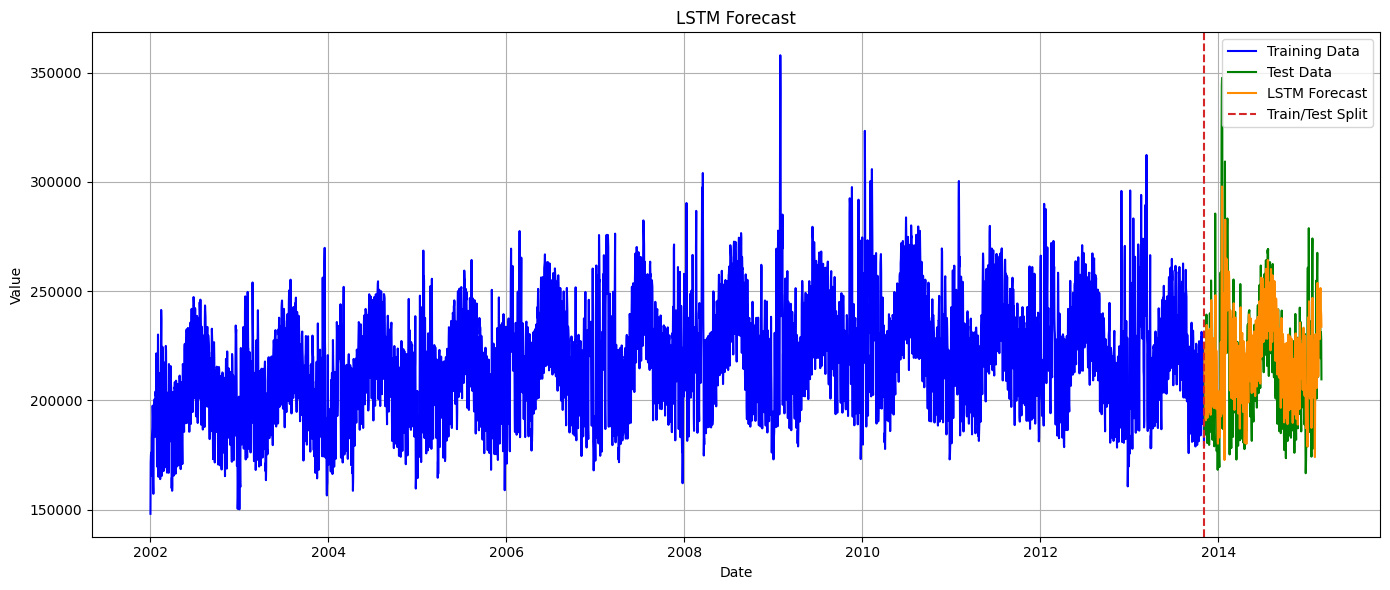

In [52]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


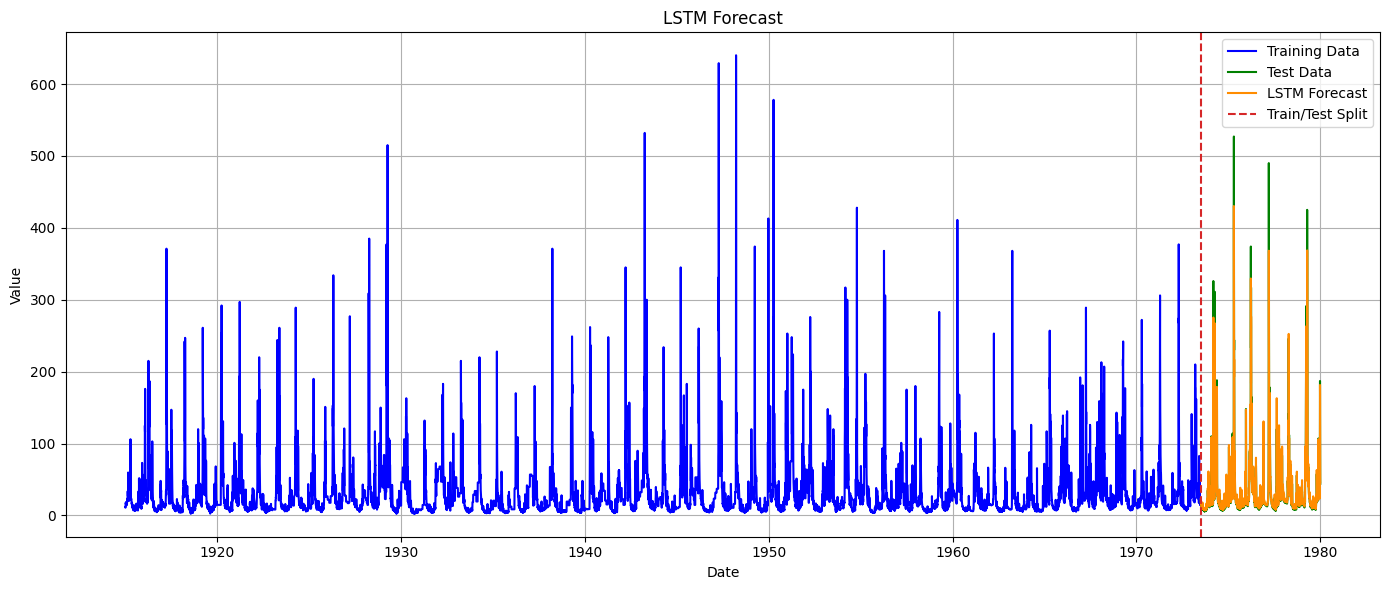

In [53]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


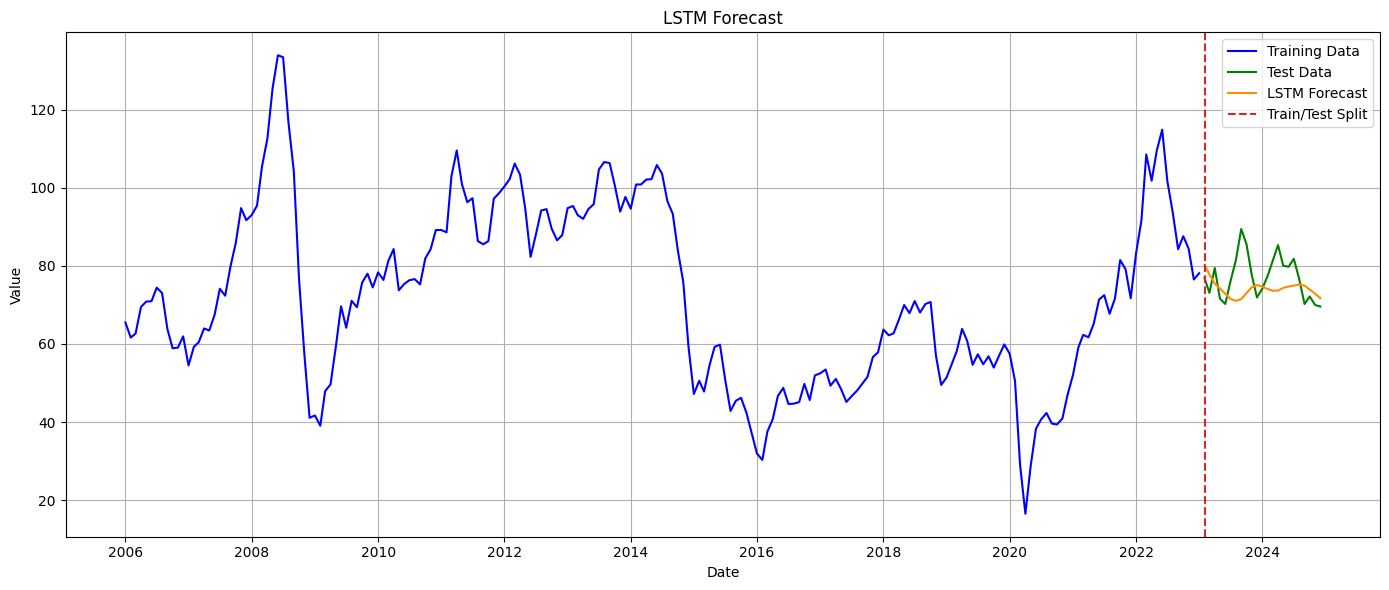

In [54]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1) 
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


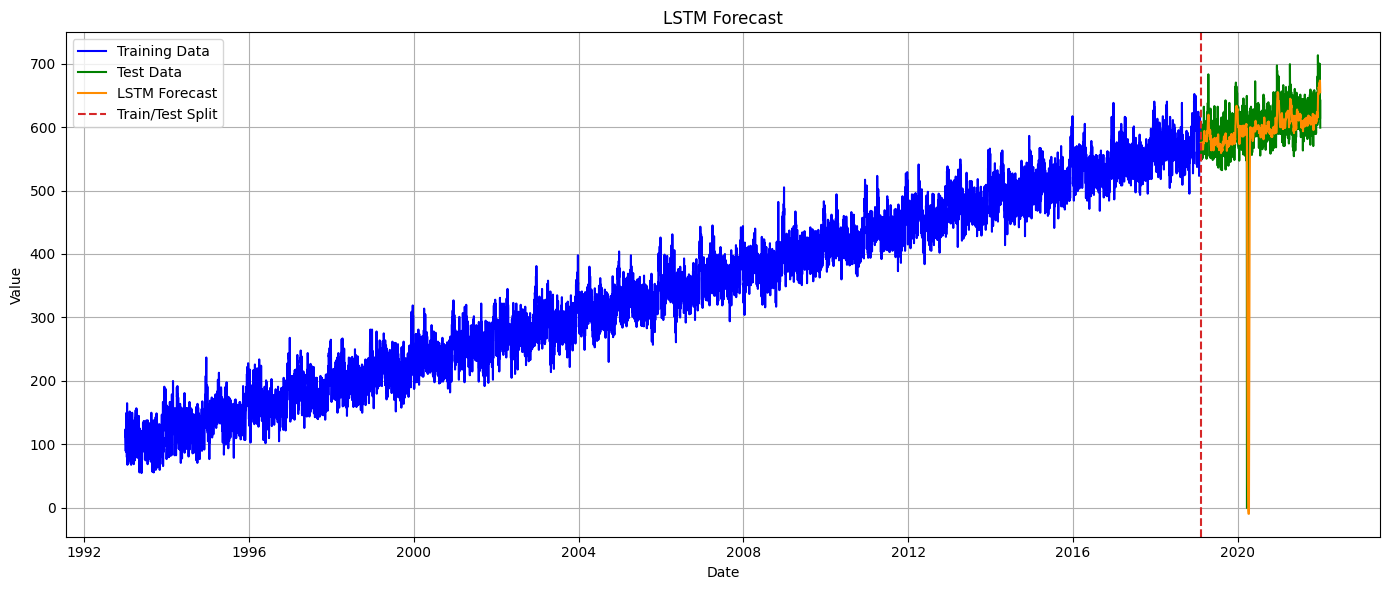

In [55]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


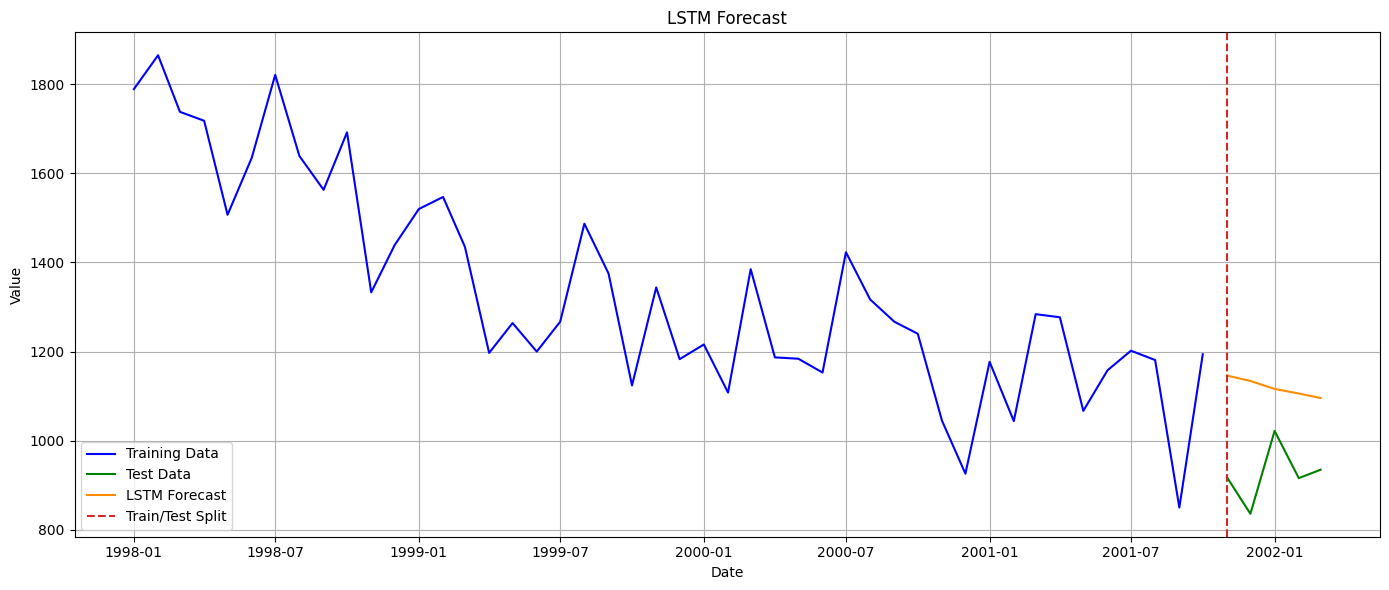

In [56]:
train_df, test_df = split_train_test(car_parts_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

----------------------------------------------------------------------------------------------------------------

Auto-inferred method name: 'lstm_forecast'


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


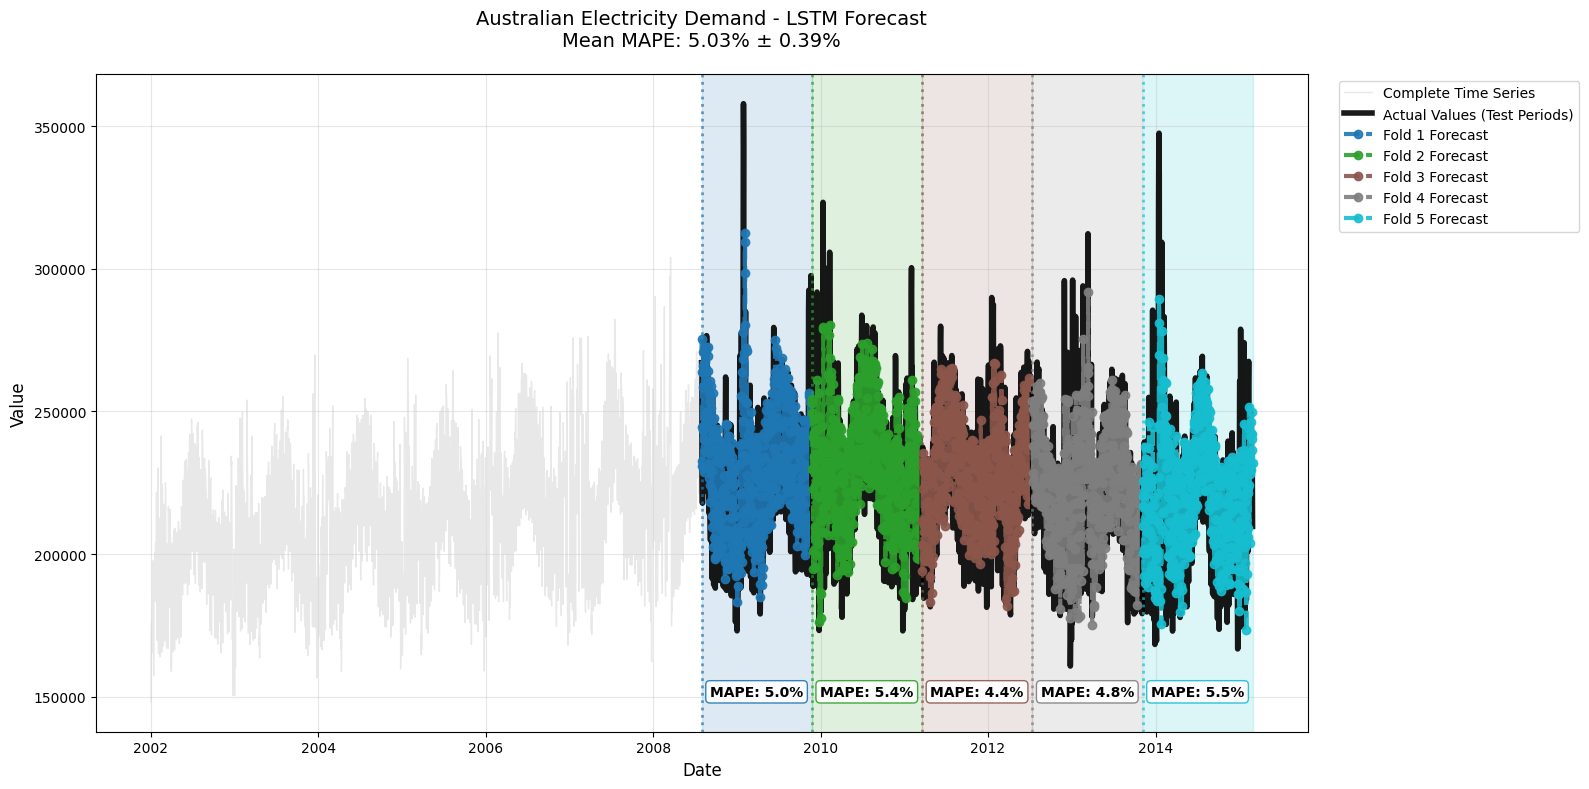


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'australian_electricity_demand'
Auto-inferred method name: 'lstm_forecast'


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


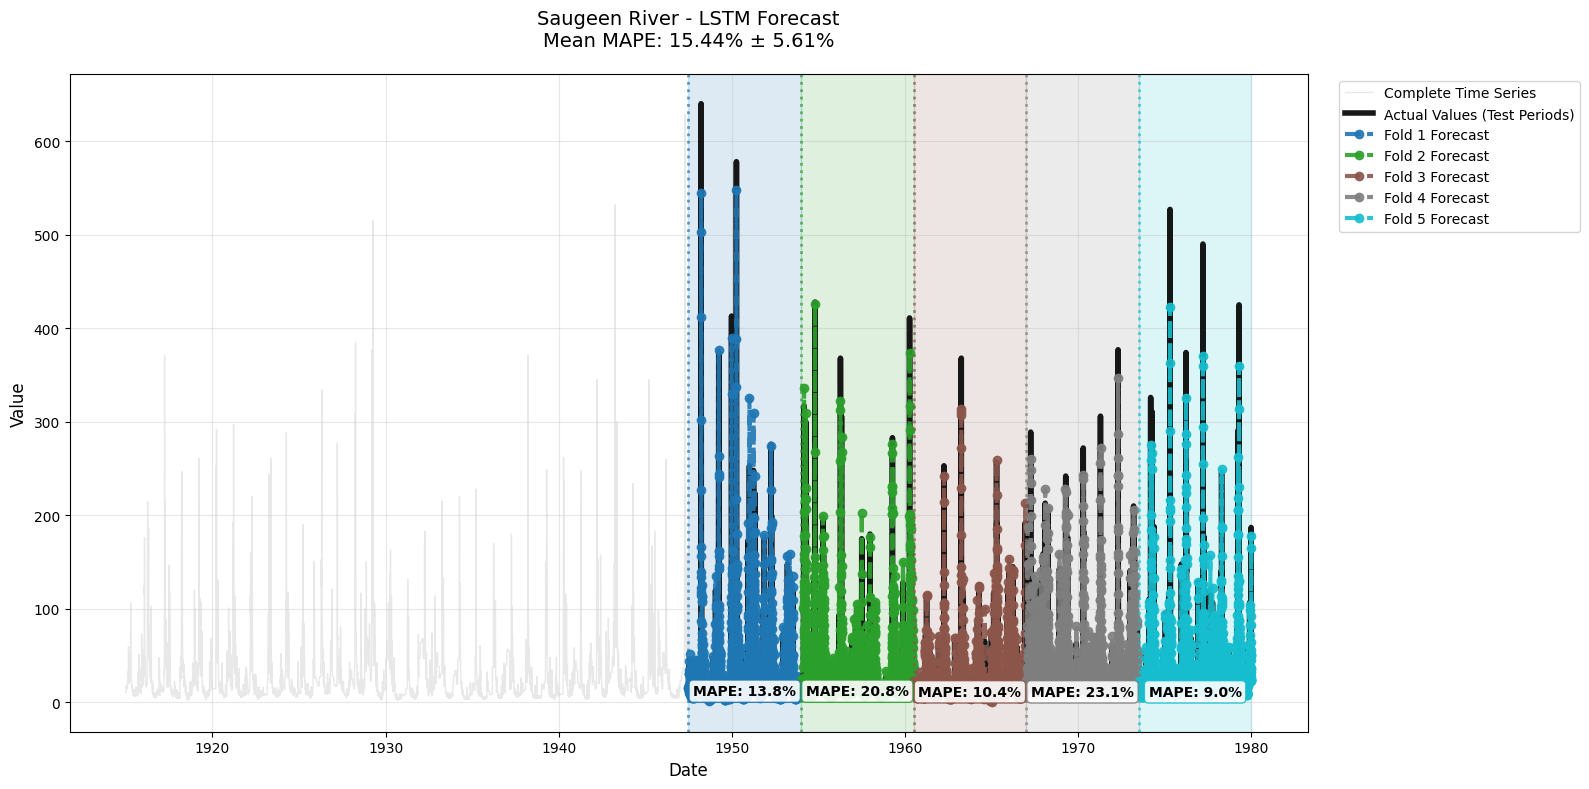


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'saugeen_river'
Auto-inferred method name: 'lstm_forecast'


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


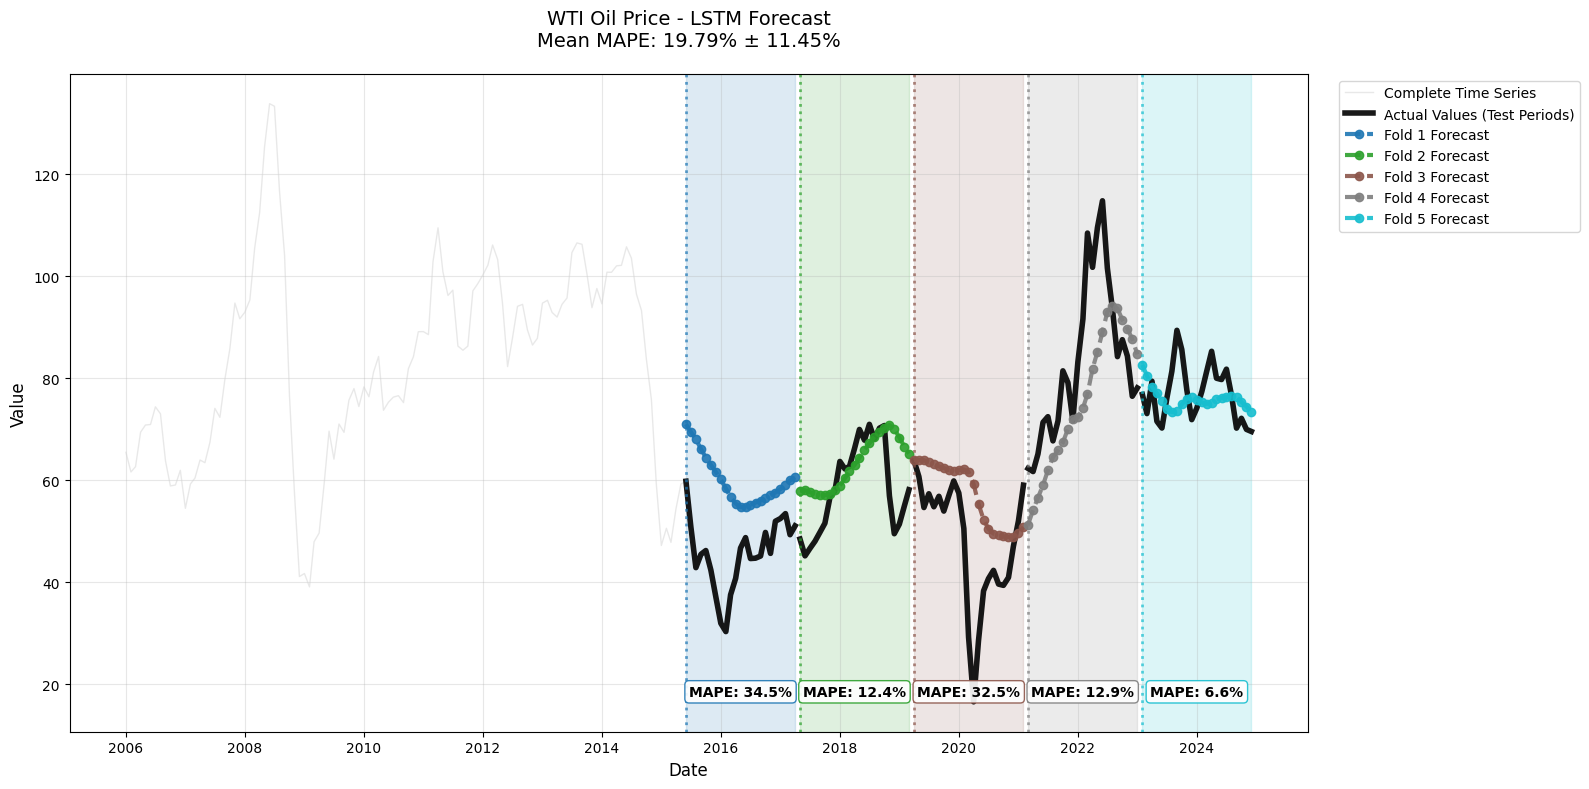


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'wti_oil'
Auto-inferred method name: 'lstm_forecast'


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


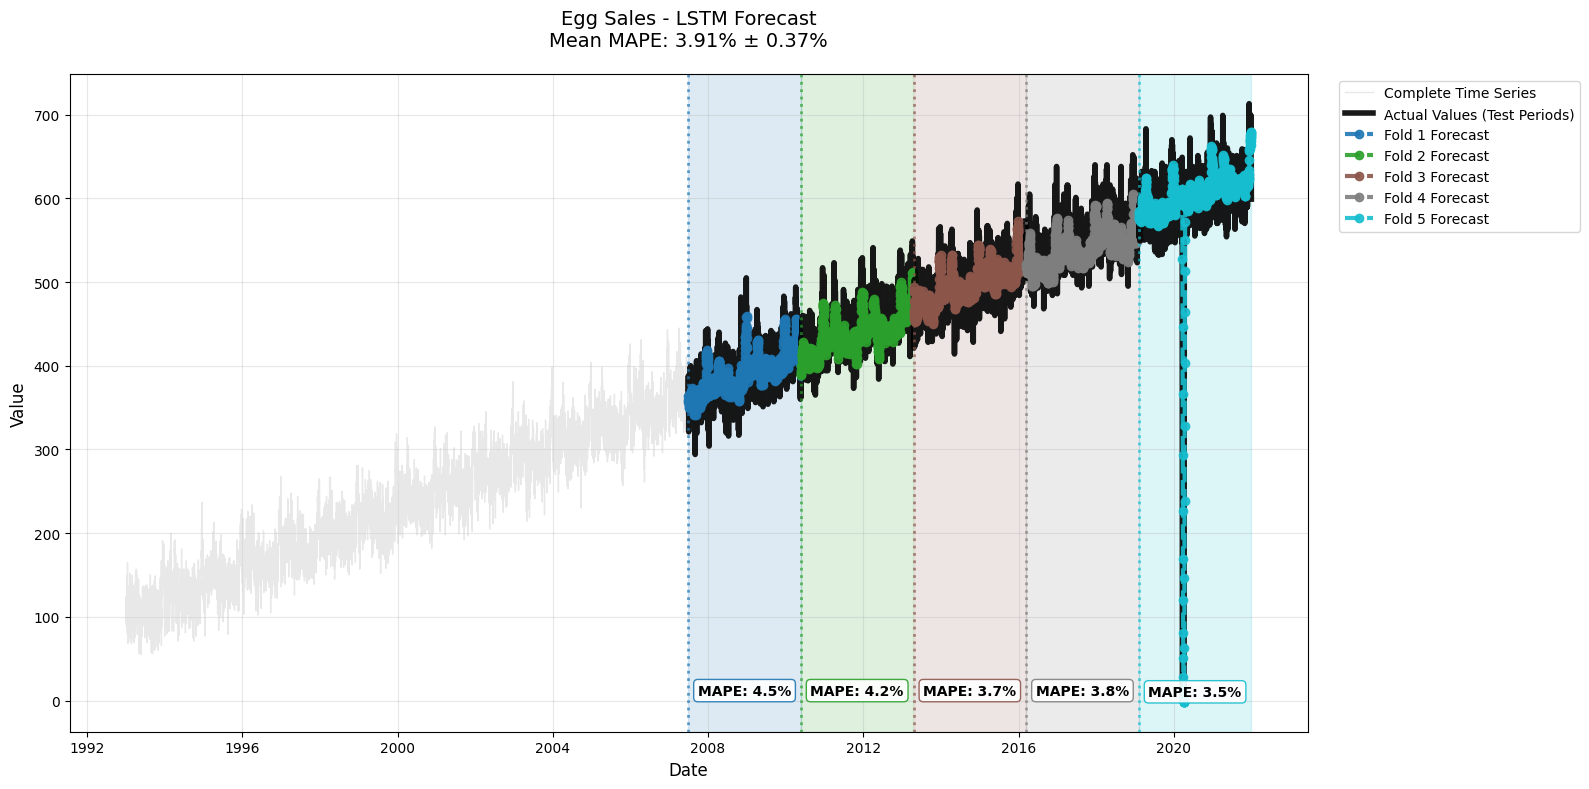


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'egg_sales'
Auto-inferred method name: 'lstm_forecast'


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


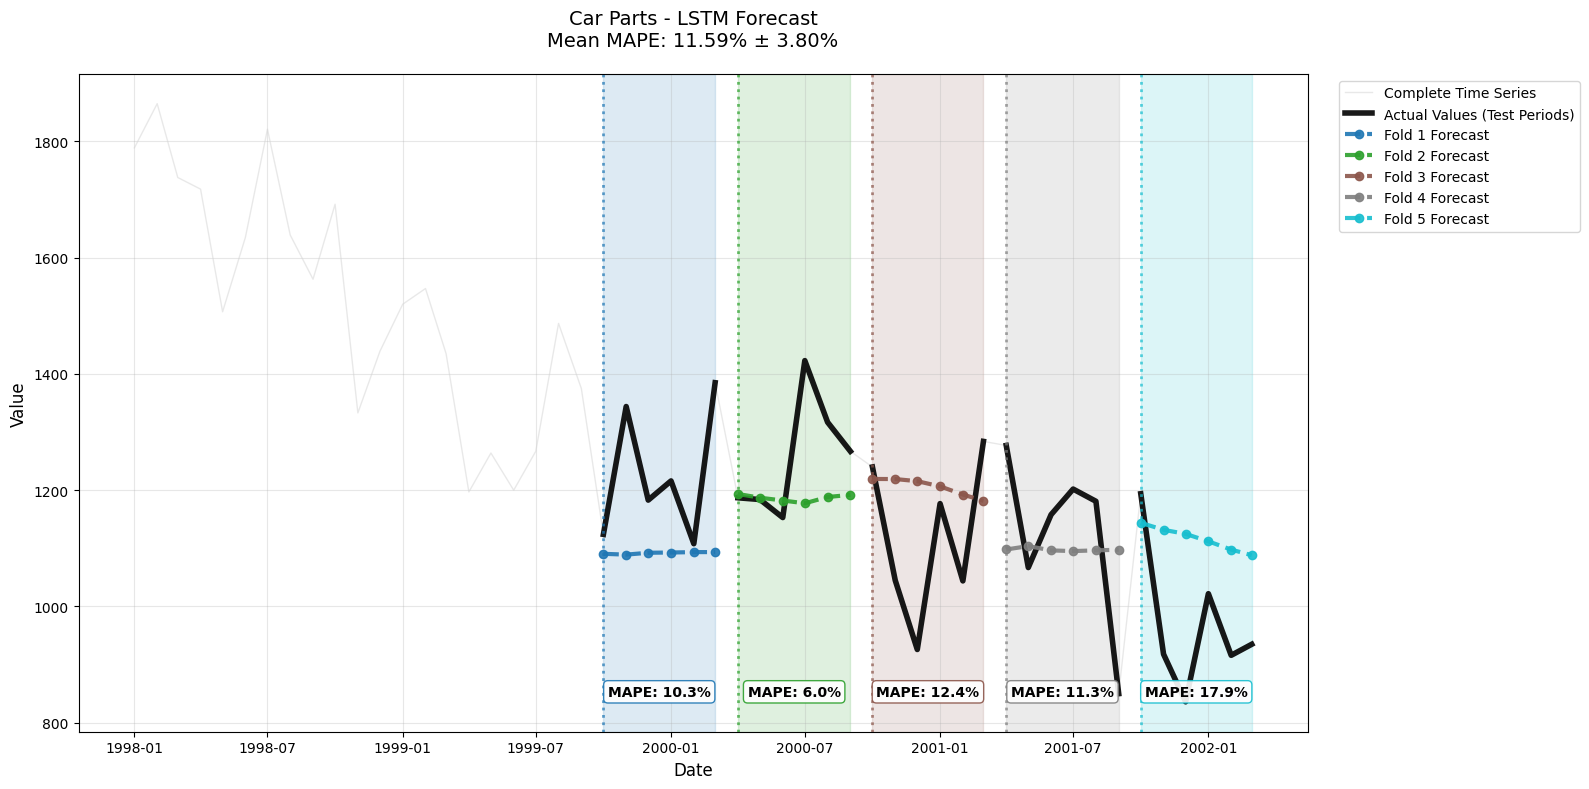


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'car_parts'


In [57]:
# cv stands for cross validation in basic_functions.ipynb
plot_comprehensive_cv_results(australian_electricity_demand_df, lstm_forecast, n_splits=5, dataset_name='australian_electricity_demand',
                              title="Australian Electricity Demand - LSTM Forecast") # Australian Electricity Demand 

plot_comprehensive_cv_results(saugeen_river_df, lstm_forecast, n_splits=5, dataset_name='saugeen_river',
                              title="Saugeen River - LSTM Forecast")

plot_comprehensive_cv_results(wti_oil_df, lstm_forecast, n_splits=5, dataset_name='wti_oil',
                              title="WTI Oil Price - LSTM Forecast")

plot_comprehensive_cv_results(egg_sales_df, lstm_forecast, n_splits=5, dataset_name='egg_sales',
                              title="Egg Sales - LSTM Forecast")

plot_comprehensive_cv_results(car_parts_df, lstm_forecast, n_splits=5, dataset_name='car_parts',
                              title="Car Parts - LSTM Forecast")
